# 데이터 소개

캐글 데이터 셋 [Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)

신용카드 이상거래 탐지

#0.기본세팅

In [5]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.font_manager as fm

# ① 설치된 나눔고딕 파일 경로 (코랩 기본 위치)
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

# ② Matplotlib 폰트 매니저에 파일을 직접 등록
fm.fontManager.addfont(font_path)

# ③ 파일에서 실제 폰트 '이름' 가져와 rcParams에 지정
prop = fm.FontProperties(fname=font_path)
mpl.rcParams['font.family'] = prop.get_name()
mpl.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

print("사용 중인 폰트:", mpl.rcParams['font.family'])

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, average_precision_score,
    classification_report, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.ensemble import IsolationForest

사용 중인 폰트: ['NanumGothic']


In [3]:
# 재현성 보장을 위해 random_state를 고정

RANDOM_STATE = 42

In [4]:
# 나눔 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (6,785 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126435 files and dire

In [6]:
# ① 설치된 나눔고딕 파일 경로 (코랩 기본 위치)
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

# ② Matplotlib 폰트 매니저에 파일을 직접 등록
fm.fontManager.addfont(font_path)

# ③ 파일에서 실제 폰트 '이름' 가져와 rcParams에 지정
prop = fm.FontProperties(fname=font_path)
mpl.rcParams['font.family'] = prop.get_name()
mpl.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

print("사용 중인 폰트:", mpl.rcParams['font.family'])

사용 중인 폰트: ['NanumGothic']


In [7]:
# 코랩 구글드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# 파일 불러오기
df = pd.read_csv("/content/drive/MyDrive/분석/신용카드_이상거래탐지/creditcard.csv")

In [10]:
# CC변수에 저장
CC = df.copy()

In [11]:
CC.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [12]:
CC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [13]:
# 결측치 확인
CC.isnull().sum()

,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


#1.타깃 불균형 확인: 정상 vs 사기 비율/건수

In [21]:
# 타깃 집계 + 사기 비율
class_counts = CC["Class"].value_counts().sort_index()  # 0=정상, 1=사기
total = int(class_counts.sum())
frauds = int(class_counts.get(1, 0))
fraud_ratio = frauds / total if total > 0 else 0.0
print(f"사기 비율(Fraud rate): {fraud_ratio*100:.4f}%  ({frauds:,}/{total:,})")

사기 비율(Fraud rate): 0.1727%  (492/284,807)


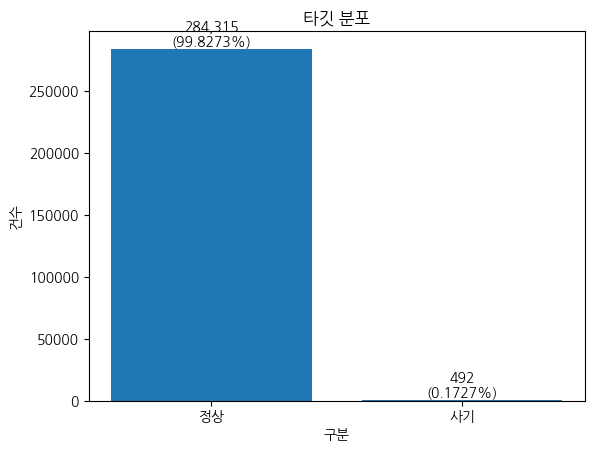

In [22]:
# 막대그래프- 불균형이 잘보임

labels = ["정상", "사기"]
values = [int(class_counts.get(0,0)), int(class_counts.get(1,0))]

plt.bar(labels, values)
plt.title("타깃 분포")
plt.xlabel("구분"); plt.ylabel("건수")
for i, v in enumerate(values):
    pct = v / total * 100
    plt.text(i, v, f"{v:,}\n({pct:.4f}%)", ha="center", va="bottom")
plt.show()

'사기'가 너무 적어서 그냥 학습하면 사기를 거의 못 잡을 수 있음

→ 가중치, SMOTE, 임계값 조정이 필요.

#2.Train/Test 분할

In [25]:
FEATURES = [c for c in CC.columns if c != "Class"]
TARGET = "Class"

X = CC[FEATURES].copy()
y = CC[TARGET].copy()


# Amount, Time은 단위가 크고 이상치에 민감해서 RobustScaler로 스케일링

num_cols_to_scale = ["Amount", "Time"]
preprocess = ColumnTransformer(
    [("scale", RobustScaler(), num_cols_to_scale)],
    remainder="passthrough" # 나머지 V1~V28은 이미 스케일됨(PCA)
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
X_train.shape, X_test.shape, y_train.mean(), y_test.mean()

((227845, 30),
 (56962, 30),
 np.float64(0.001729245759178389),
 np.float64(0.0017204452090867595))

학습 227,845건 / 평가 56,962건 / 피처 30개

학습·평가 모두 사기 비율이 0.17%로 같음 → 층화 분할 성공(공정한 비교 가능)

#3.베이스라인 모델: 로지스틱 회귀(가중치) + ROC/PR 가로 그래프

[로지스틱] ROC-AUC: 0.9720  |  PR-AUC(AP): 0.7175


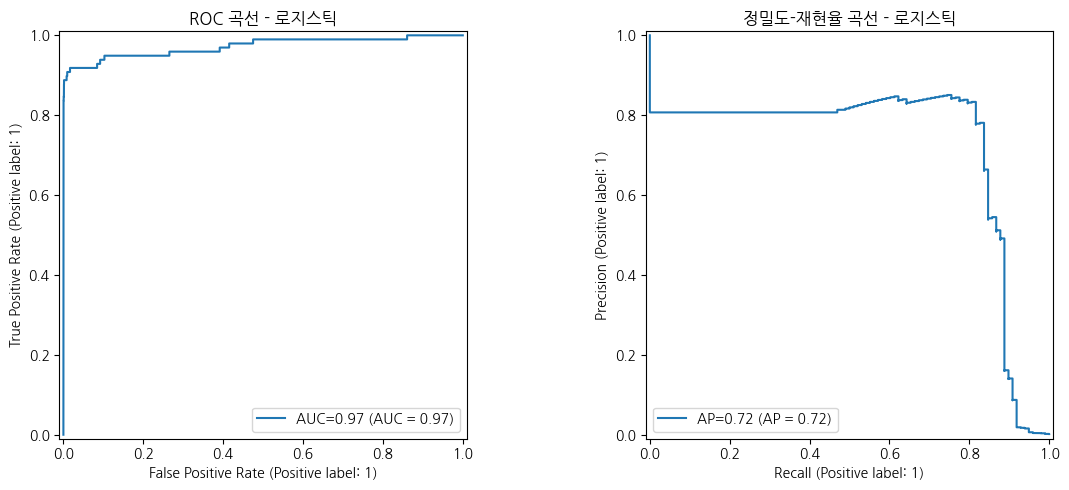

In [29]:
# 로지스틱 파이프라인: (전처리 → 모델)
logit_pipe = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(
        max_iter=500,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ))
])

# 학습 & 예측 확률
logit_pipe.fit(X_train, y_train)
proba_val = logit_pipe.predict_proba(X_test)[:, 1]

# 성능 지표
roc = roc_auc_score(y_test, proba_val)
ap  = average_precision_score(y_test, proba_val)
print(f"[로지스틱] ROC-AUC: {roc:.4f}  |  PR-AUC(AP): {ap:.4f}")

# 그래프
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

RocCurveDisplay.from_predictions(y_test, proba_val, ax=axes[0], name=f"AUC={roc:.2f}")
axes[0].set_title("ROC 곡선 - 로지스틱")

PrecisionRecallDisplay.from_predictions(y_test, proba_val, ax=axes[1], name=f"AP={ap:.2f}")
axes[1].set_title("정밀도-재현율 곡선 - 로지스틱")
axes[1].legend(loc="lower left")

plt.tight_layout()
plt.show()

가중치로 '사기'의 중요도를 키워 학습.

ROC-AUC : 0.97 (전체 분리력 아주 좋음), PR-AUC : 0.72(소수 클래스 기준 성능).

PR곡선이 높게 유지되다 재현율 0.8-0.9 구간에서 급하락
→ 많이 잡으려면(재현율↑) 오탐도 늘어남.

#4.불균형 보강: SMOTE + 로지스틱 비교

[SMOTE+로지스틱] ROC-AUC(CV평균): 0.9802 ± 0.0124
[SMOTE+로지스틱] PR-AUC(AP, 홀드아웃): 0.7251


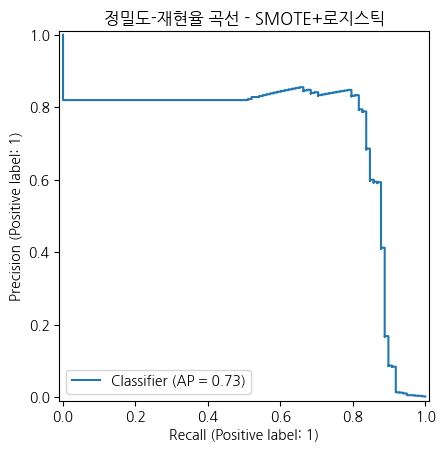

In [30]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

smote_logit = ImbPipeline([
    ("prep", preprocess),
    ("smote", SMOTE(random_state=RANDOM_STATE, k_neighbors=5)),
    ("clf", LogisticRegression(max_iter=500, random_state=RANDOM_STATE))
])

# CV로 ROC-AUC 평균만 빠르게 확인
roc_scores = cross_val_score(smote_logit, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)

# 홀드아웃 PR-AUC
smote_logit.fit(X_train, y_train)
proba_val = smote_logit.predict_proba(X_test)[:, 1]
ap = average_precision_score(y_test, proba_val)

print(f"[SMOTE+로지스틱] ROC-AUC(CV평균): {roc_scores.mean():.4f} ± {roc_scores.std():.4f}")
print(f"[SMOTE+로지스틱] PR-AUC(AP, 홀드아웃): {ap:.4f}")

PrecisionRecallDisplay.from_predictions(y_test, proba_val);
plt.title("정밀도-재현율 곡선 - SMOTE+로지스틱"); plt.show()

학습세트에서만 사기 샘플을 합성해 조금 더 균형을 맞춤.

<결과>


ROC-AUC(CV 평균) = 0.9802 ± 0.0124 = 평균 0.98, 표준편차 0.012.
  -  로지스틱(가중치)보다 약간 상승.

PR-AUC(AP, 홀드아웃) = 0.7251
  - 베이스라인(0.7175)보다 소폭 상승.



즉, ROC-AUC 0.98, PR-AUC 0.725로 베이스라인 대비 소폭 향상했습니다.

#5.더 강한 모델: 랜덤포레스트 + 임계값(Threshold) 찾기

트리 앙상블이라 비선형/상호작용을 자동으로 학습 → 보통 로지스틱보다 표현력이 강함.

In [33]:
rf_pipe = Pipeline([
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=200, max_depth=12, min_samples_leaf=4,
        max_features="sqrt", bootstrap=True, max_samples=0.7,
        class_weight="balanced_subsample", n_jobs=-1, random_state=RANDOM_STATE, verbose=1
    ))
])

rf_pipe.fit(X_train, y_train)
rf_proba = rf_pipe.predict_proba(X_test)[:,1]

# 임계값 0.50과 F1 최대 임계값에서 각각 평가
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
def eval_at(thr, name):
    y_pred = (rf_proba >= thr).astype(int)
    print(f"\n[{name}] 임계값={thr:.3f}")
    print(classification_report(y_test, y_pred, target_names=["정상(0)","사기(1)"]))
    print("혼동행렬:\n", confusion_matrix(y_test, y_pred))

eval_at(0.50, "랜덤포레스트 기본")

prec, rec, thr = precision_recall_curve(y_test, rf_proba)
f1 = 2*prec*rec/(prec+rec+1e-9)
best_thr = thr[np.argmax(f1[:-1])]   # thresholds 길이는 len(prec)-1
eval_at(best_thr, "랜덤포레스트(F1 최대)")
print(f"\nF1 최대 임계값 ≈ {best_thr:.3f}")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   55.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  4.0min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s



[랜덤포레스트 기본] 임계값=0.500
              precision    recall  f1-score   support

       정상(0)       1.00      1.00      1.00     56864
       사기(1)       0.86      0.83      0.84        98

    accuracy                           1.00     56962
   macro avg       0.93      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962

혼동행렬:
 [[56851    13]
 [   17    81]]

[랜덤포레스트(F1 최대)] 임계값=0.560
              precision    recall  f1-score   support

       정상(0)       1.00      1.00      1.00     56864
       사기(1)       0.88      0.82      0.85        98

    accuracy                           1.00     56962
   macro avg       0.94      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962

혼동행렬:
 [[56853    11]
 [   18    80]]

F1 최대 임계값 ≈ 0.560


[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.7s finished


트리 앙상블이라 비선형/상호작용을 자동 학습 → 가장 잘 나옴.

임계값 0.50일 때 혼동행렬 예시 [[TN=56851, FP=13],[FN=17, TP=81]]

FP 13건(정상인데 사기라고 경보), FN 17건(사기인데 못 잡음).

F1최대 임계값 0.56으로 올리면

FP가 줄고(오탐↓), FN이 약간 늘어남(미탐↑) → 정밀도↑, 재현율↓의 정책 선택 문제.

표에서도 보이듯 PR-AUC ≈ 0.847로 가장 높음 → 실무 1순위.

#6.비지도 보조선: Isolation Forest로 신규 패턴 감지

In [34]:
# 전처리 결과를 따로 추출
X_train_prep = preprocess.fit_transform(X_train)
X_test_prep  = preprocess.transform(X_test)

iso = IsolationForest(
    n_estimators=300, contamination=y.mean(),  # 대략적 사기 비율
    random_state=RANDOM_STATE, n_jobs=-1
)
iso.fit(X_train_prep)                     # y 없이 학습
iso_pred = iso.predict(X_test_prep)       # 정상=1, 이상=-1
iso_pred = np.where(iso_pred == -1, 1, 0) # 사기=1로 변환

print("\n[Isolation Forest] 비지도 결과")
print(classification_report(y_test, iso_pred, target_names=["정상(0)","사기(1)"]))
print("혼동행렬:\n", confusion_matrix(y_test, iso_pred))


[Isolation Forest] 비지도 결과
              precision    recall  f1-score   support

       정상(0)       1.00      1.00      1.00     56864
       사기(1)       0.23      0.26      0.24        98

    accuracy                           1.00     56962
   macro avg       0.62      0.63      0.62     56962
weighted avg       1.00      1.00      1.00     56962

혼동행렬:
 [[56782    82]
 [   73    25]]


라벨 없이 “이상치”만 찾는 방법.

여기서는 정밀도 0.23 / 재현율 0.26 → 단독 운영은 비추.

다만 새로운 유형 탐지 보조선으로는 의미 있음(지도학습이 놓친 특이 패턴 발굴).

#7.최종 요약 테이블 (정밀도/재현율/ROC-AUC/PR-AUC)

In [35]:
def summarize(name, prob, thr):
    y_pred = (prob >= thr).astype(int)
    from sklearn.metrics import precision_score, recall_score, f1_score
    return {
        "모델": name,
        "임계값": round(thr,3),
        "정밀도": round(precision_score(y_test, y_pred), 3),
        "재현율": round(recall_score(y_test, y_pred), 3),
        "F1": round(f1_score(y_test, y_pred), 3),
        "ROC-AUC": round(roc_auc_score(y_test, prob), 3),
        "PR-AUC": round(average_precision_score(y_test, prob), 3),
    }

base_logit = summarize("로지스틱(0.50)", logit_pipe.predict_proba(X_test)[:,1], 0.50)
smote_log  = summarize("SMOTE+로지스틱(0.50)", smote_logit.predict_proba(X_test)[:,1], 0.50)
rf_050     = summarize("랜덤포레스트(0.50)", rf_proba, 0.50)
rf_best    = summarize("랜덤포레스트(F1최대)", rf_proba, best_thr)

pd.DataFrame([base_logit, smote_log, rf_050, rf_best])

,모델,임계값,정밀도,재현율,F1,ROC-AUC,PR-AUC
0,로지스틱(0.50),0.50,0.061,0.918,0.114,0.972,0.717
1,SMOTE+로지스틱(0.50),0.50,0.059,0.918,0.111,0.971,0.725
2,랜덤포레스트(0.50),0.50,0.862,0.827,0.844,0.978,0.847
3,랜덤포레스트(F1최대),0.56,0.879,0.816,0.847,0.978,0.847


미탐을 최소화(사기를 놓치면 큰 손해) → 랜덤포레스트에서 임계값 낮게

오탐을 줄이기(업무량/고객 불편 최소) → 랜덤포레스트에서 임계값 높게

“랜덤포레스트 + 임계값 정책으로 운영 목표(미탐vs오탐)에 맞춰 경보량을 조절할 수 있습니다.”